# Exploratory Data Analysis

**Ziele**:
- Daten verstehen
- Eventuelle Probleme identifizieren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

import re
import os
from collections import Counter
from utils.text_utils import clean_text

nltk.download('punkt')
nltk.download('stopwords')
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['font.size'] = 18 

[nltk_data] Downloading package punkt to /home/x/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/x/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Herunterladen der Datasets
Wir nutzen die Kaggle API um zwei Datensaetze herunterzuladen. Damit die Authentifizierung ohne Probleme funktioniert, muss zunaechst ein Kaggle Account angelegt werden und anschliessend ein enstprechender Access Token generiert werden. 

Datensaetze:
- McDonalds Reviews
- IMDB Reviews
- (Amazon Food Reviews)

**Wichtig:** Falls Google Colab genutzt wird, muss die `kaggle.json` (enthaelt die API credentials) hochgeladen werden. Andernfalls kann der naechste Schritt ubersprungen werden.

In [2]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download McDonalds dataset
if not os.path.exists('mcdonalds-store-reviews.zip'):
    print("Downloading McDonalds dataset...")
    !kaggle datasets download -d nelgiriyewithana/mcdonalds-store-reviews
if os.path.exists('mcdonalds-store-reviews.zip'):
    print("Unzipping McDonalds dataset...")
    !unzip -n mcdonalds-store-reviews.zip

# Download IMDB dataset
if not os.path.exists('imdb-dataset-of-50k-movie-reviews.zip'):
    print("Downloading IMDB dataset...")
    !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
if os.path.exists('imdb-dataset-of-50k-movie-reviews.zip'):
    print("Unzipping IMDB dataset...")
    !unzip -n imdb-dataset-of-50k-movie-reviews.zip

Unzipping McDonalds dataset...
/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Archive:  mcdonalds-store-reviews.zip
Unzipping IMDB dataset...
/usr/bin/zsh: /home/x/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
Archive:  imdb-dataset-of-50k-movie-reviews.zip


## Laden der Datensaetze

In [4]:
df_mcd = pd.read_csv('McDonald_s_Reviews.csv', encoding='latin-1')
df_imdb = pd.read_csv('IMDB Dataset.csv')

## Erster Ueberblick 

**McDonalds Reviews**

In [5]:
df_mcd.head()   

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


**IMDB Reviews**

In [6]:
df_imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Neben Reviewtexten und Bewertungen sind in den Datensaetzen einige weitere Daten enthalten. Da wir folgend nur an den Textdaten und dessen Bewertung interessiert sind, koennen wir diese herausziehen.

In [7]:
# Only keep the text and the sentiment
df_mcd = df_mcd[['review', 'rating']]
df_imdb = df_imdb[['review', 'sentiment']]  

Ebenfalls koennen wir sehen, dass die Label 'categorical' sind und in form eines strings vorliegen. Um die Label besser verwenden zu koennen werden diese zunaechst in ein numerisches Format umgewandelt. Fuer das Imdb Dataset wird `positive` zu `1` und `negative` zu `0`. Selbes bei den McDonald Reviews, `1 star` entspricht `1` und `5 stars` entspricht `5`.

Grundsaetzlich laesst sich bereits sagen, dass die Klassifizierungsprobleme hier einmal eine 'Binary Classification' und einmal eine 'Multi-Class Classification' sind. Fuer die Visualiserung ist dieses zunaechst kein Problem, allerdings muss bei einer spaeteren Zusammenfuerhung beachtet werden inwiefern die kategorialen daten entweder zu positv (1) oder negativ (0) umgewandelt werden.

In [8]:
mcd_rating_map = {
    '1 star': 1,
    '2 stars': 2,
    '3 stars': 3,
    '4 stars': 4,
    '5 stars': 5,
}
df_mcd['rating'] = df_mcd['rating'].map(mcd_rating_map)
df_imdb['sentiment'] = df_imdb['sentiment'].map({'positive': 1, 'negative': 0})

# Align column names
df_mcd = df_mcd.rename(columns={'review': 'text', 'rating': 'sentiment'})
df_imdb = df_imdb.rename(columns={'review': 'text', 'sentiment': 'sentiment'})

Das McDonalds und Amazon Dataset haben nachwievor kategorial gelabelte Reviews 1-5, das IMDB Dataset hingegen hat nur binary label mit 0-1. 

In [9]:
df_mcd.head()   

,text,sentiment
0,Why does it look like someone spit on my food?...,1
1,It'd McDonalds. It is what it is as far as the...,4
2,Made a mobile order got to the speaker and che...,1
3,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5
4,"I repeat my order 3 times in the drive thru, a...",1


In [10]:
df_mcd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       33396 non-null  object
 1   sentiment  33396 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 521.9+ KB


In [11]:
df_imdb.head(5) 

,text,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [12]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


### Anzal der Eintraege

In [13]:
print("McDonalds dataset has {} entries".format(len(df_mcd)))
for i in range(1, 6):
    print("McDonalds dataset has {} entries with {} stars".format(len(df_mcd[df_mcd['sentiment'] == i]), i))

print('-' * 50)

print("IMDB dataset has {} entries".format(len(df_imdb)))
for i in range(0, 2):
    print("IMDB dataset has {} entries with {} sentiment".format(len(df_imdb[df_imdb['sentiment'] == i]), 'positive' if i == 1 else 'negative'))

McDonalds dataset has 33396 entries
McDonalds dataset has 9431 entries with 1 stars
McDonalds dataset has 3086 entries with 2 stars
McDonalds dataset has 4818 entries with 3 stars
McDonalds dataset has 5787 entries with 4 stars
McDonalds dataset has 10274 entries with 5 stars
--------------------------------------------------
IMDB dataset has 50000 entries
IMDB dataset has 25000 entries with negative sentiment
IMDB dataset has 25000 entries with positive sentiment


## Rating / Sentiment Verteilung

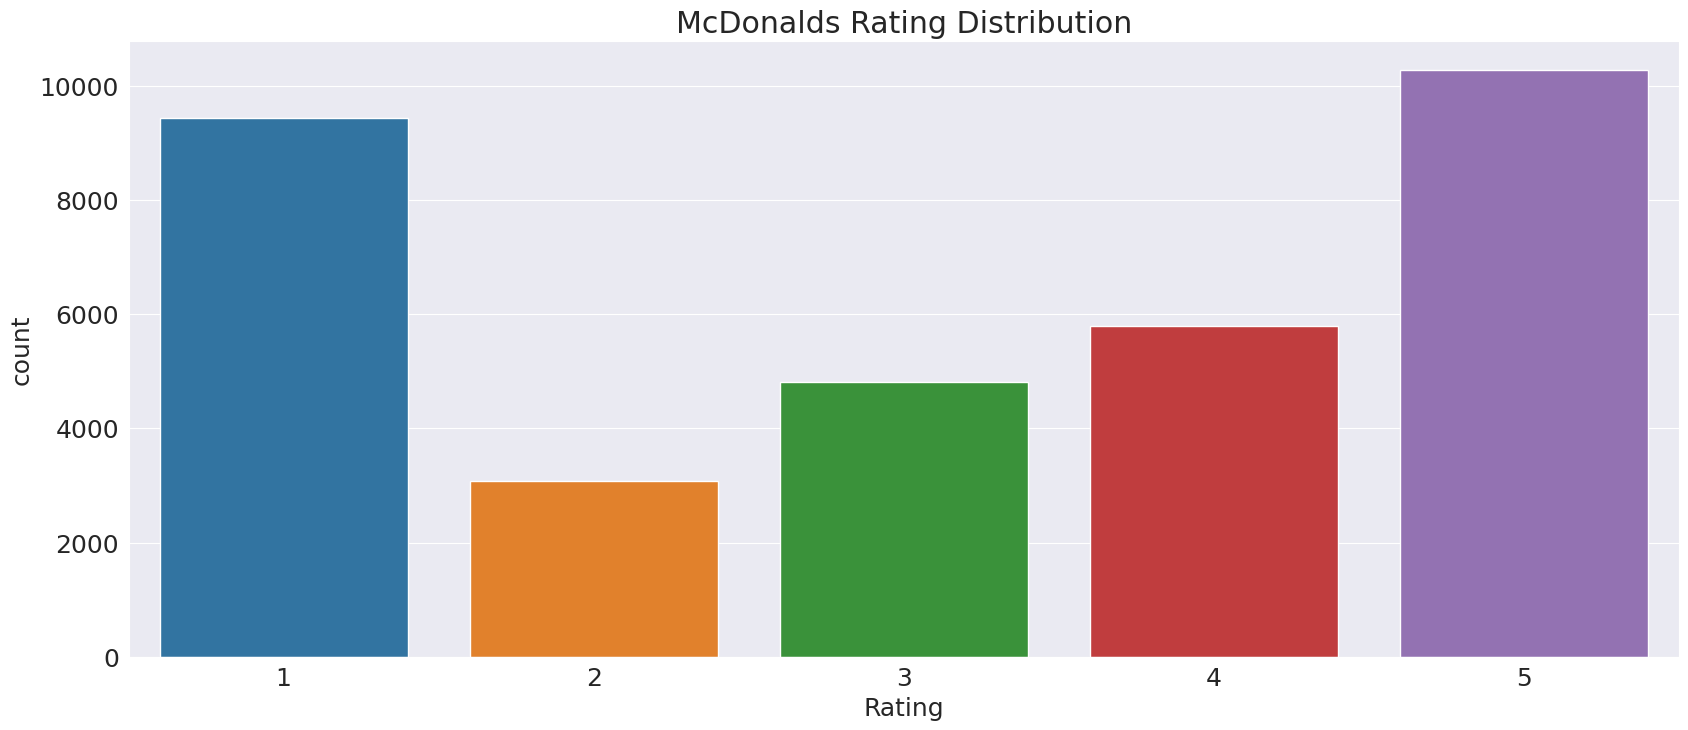

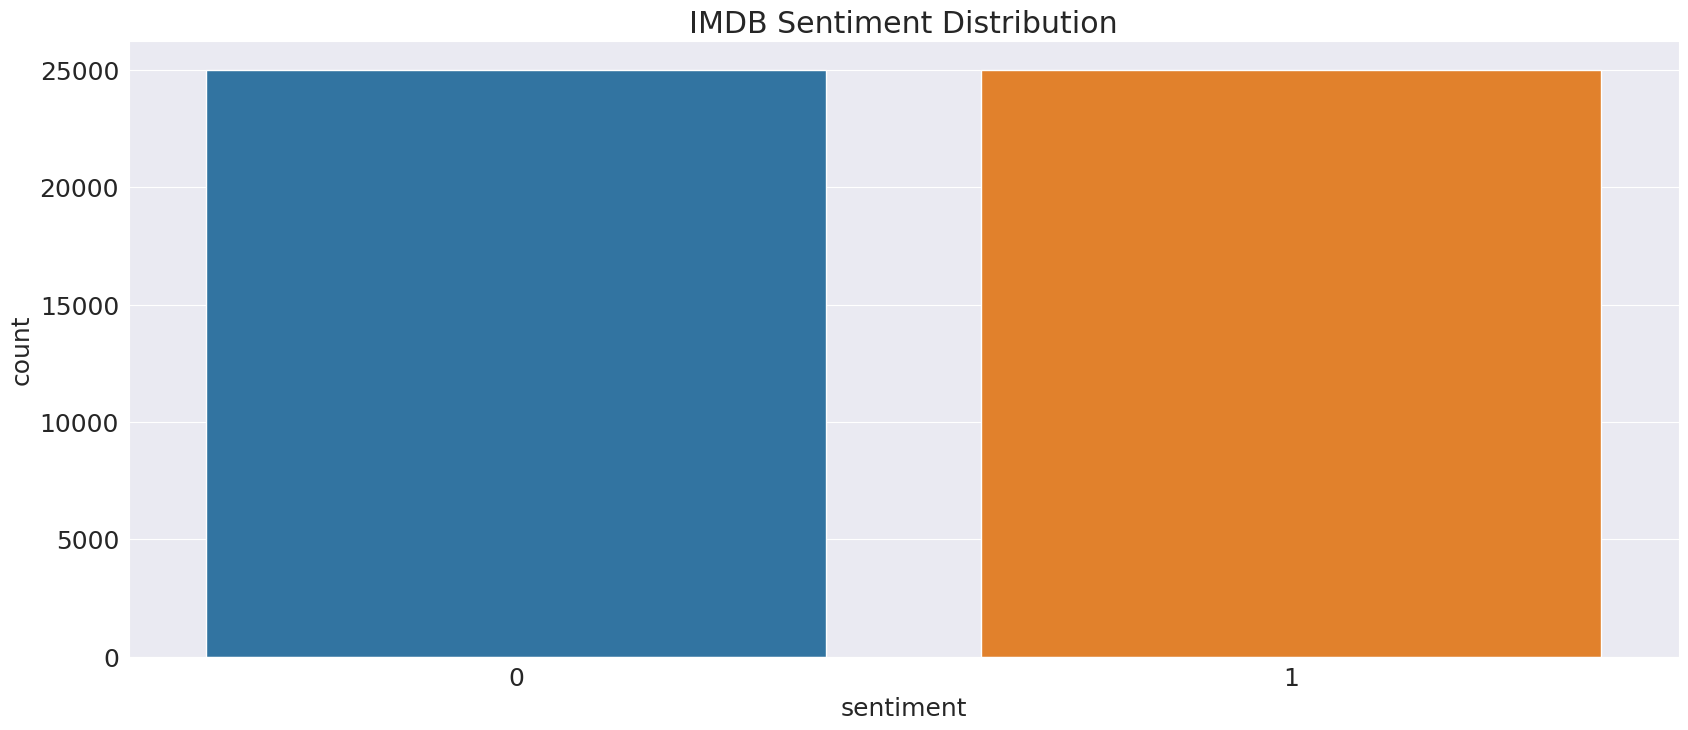

In [14]:
# McDonalds Rating Distribution
sns.countplot(x='sentiment', data=df_mcd)
plt.title('McDonalds Rating Distribution')
plt.xlabel('Rating')
plt.show()

# IMDB Sentiment Distribution
sns.countplot(x='sentiment', data=df_imdb)
plt.title('IMDB Sentiment Distribution')    
plt.show()

## Genauere Betrachtung das McDonalds Datasets

- Charakteranzahl pro Kategorie
- Wortanzahl pro Kategorie 
- Durschnittliche Wortlaenge pro Kategorie
- Durchschnittliche Satzlaenge pro Kategorie 
- Meistvorkommende Woerter 
- Meistvorkommende BiGrams

In [15]:
df_mcd['char_count'] = df_mcd['text'].apply(len)
df_mcd['word_count'] = df_mcd['text'].apply(lambda x: len(word_tokenize(x)))
df_mcd['mean_word_length'] = df_mcd['text'].apply(lambda x: np.mean([len(word) for word in word_tokenize(x)]))
df_mcd['sent_count'] = df_mcd['text'].apply(lambda x: len(sent_tokenize(x)))
df_mcd['mean_sent_length'] = df_mcd['word_count'] / df_mcd['sent_count']  
df_mcd.head()     

,text,sentiment,char_count,word_count,mean_word_length,sent_count,mean_sent_length
0,Why does it look like someone spit on my food?...,1,259,60,3.466667,3,20.0
1,It'd McDonalds. It is what it is as far as the...,4,237,49,4.000000,5,9.8
2,Made a mobile order got to the speaker and che...,1,415,74,4.662162,5,14.8
3,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5,176,14,11.714286,2,7.0
4,"I repeat my order 3 times in the drive thru, a...",1,312,69,3.550725,2,34.5


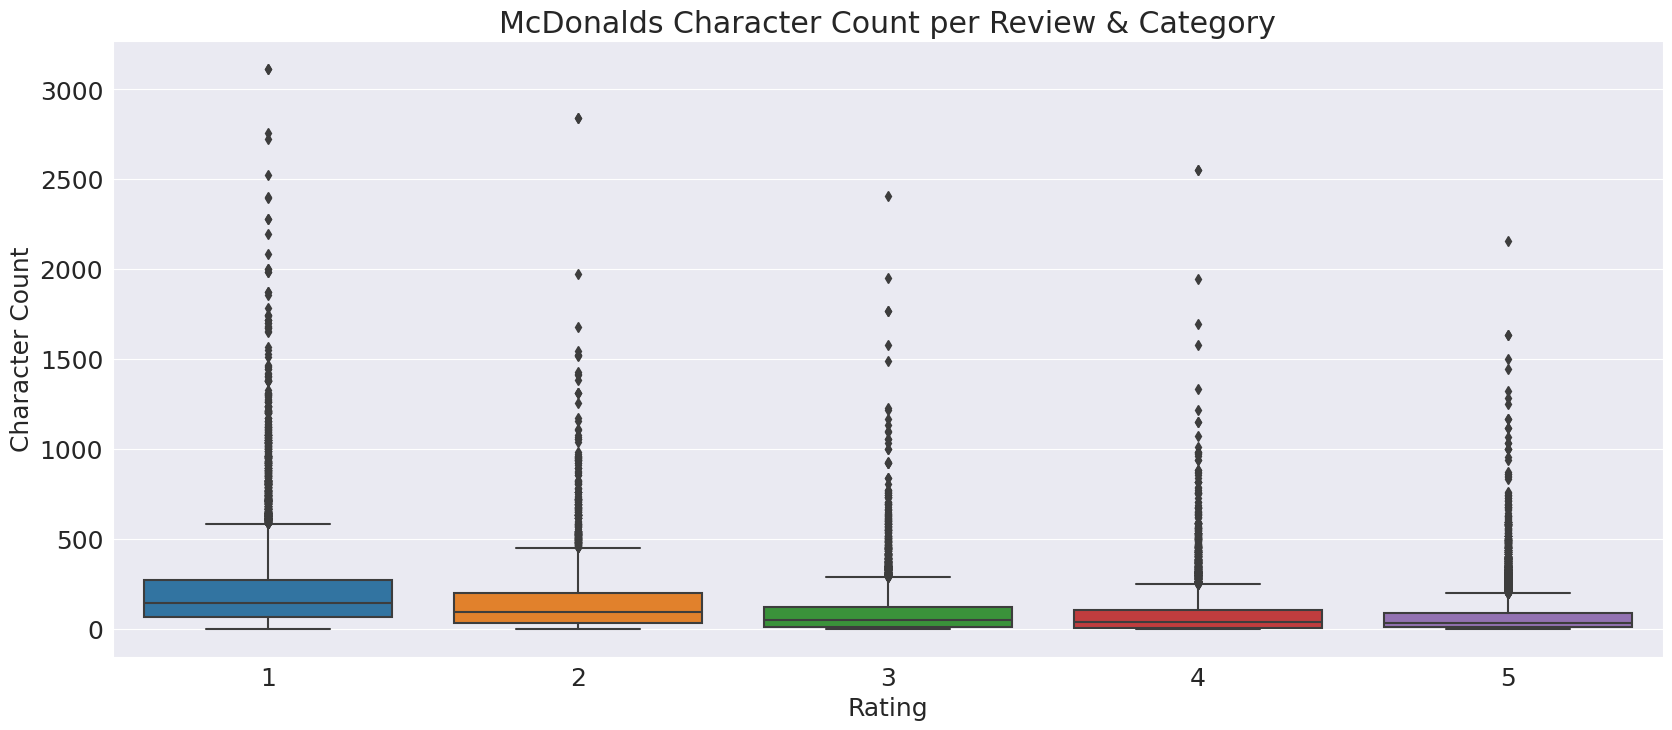

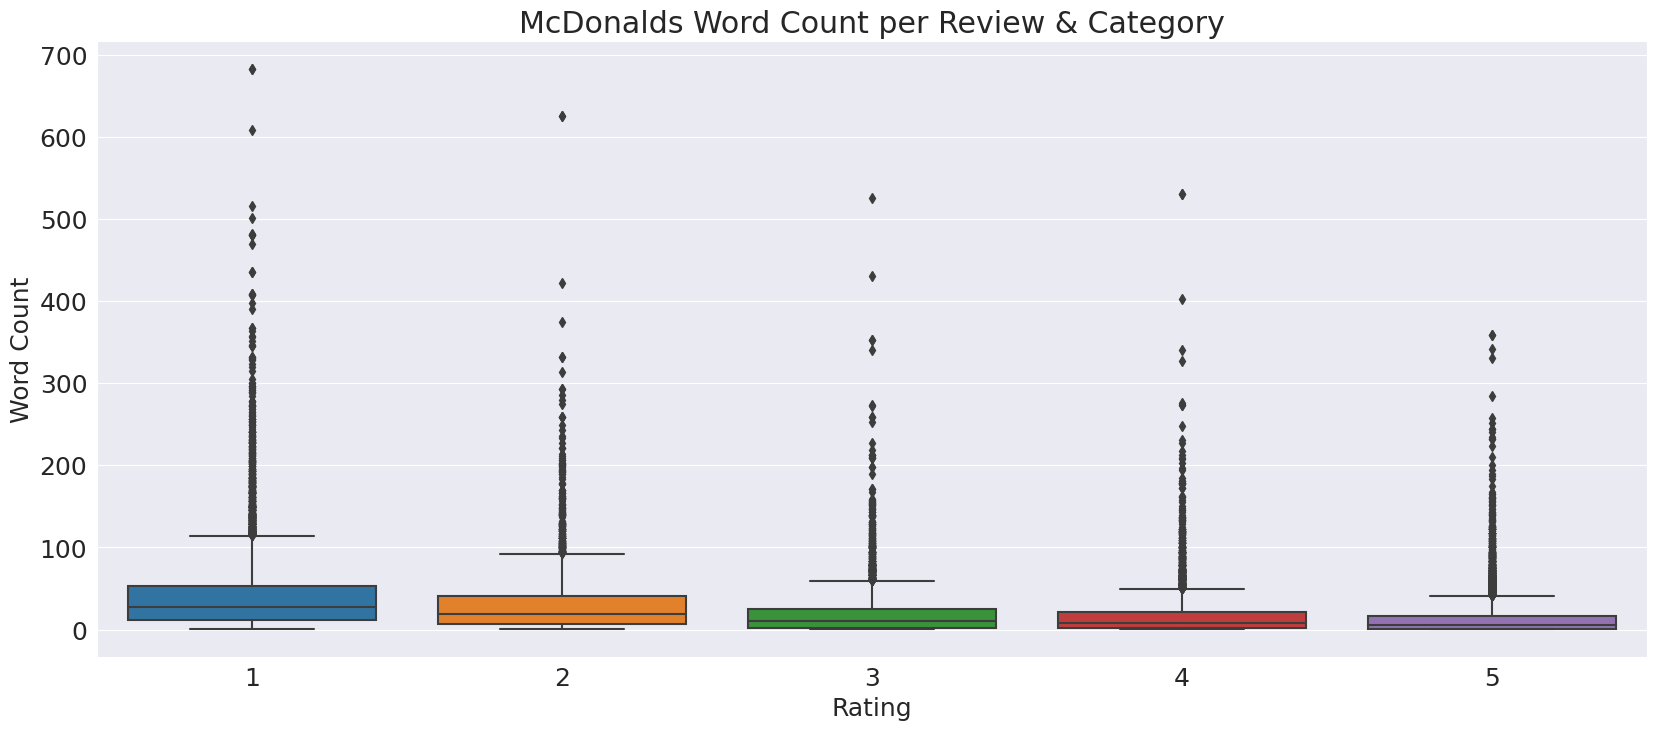

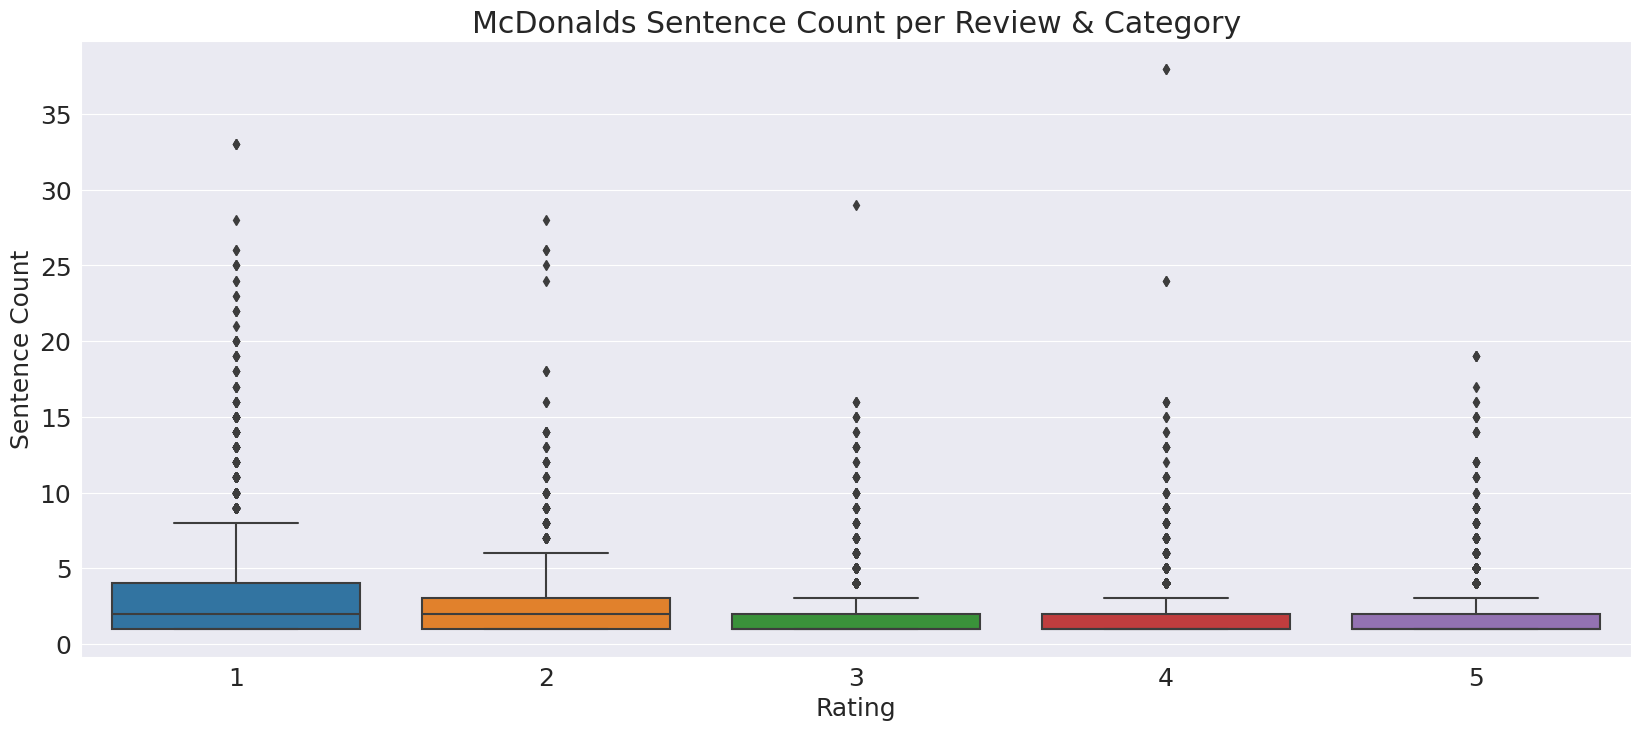

In [16]:
# character count
sns.boxplot(x='sentiment', y='char_count', data=df_mcd)
plt.title('McDonalds Character Count per Review & Category')
plt.xlabel('Rating')
plt.ylabel('Character Count')   
plt.show()

# word count
sns.boxplot(x='sentiment', y='word_count', data=df_mcd) 
plt.title('McDonalds Word Count per Review & Category')
plt.xlabel('Rating')
plt.ylabel('Word Count')
plt.show()

# sentence cound 
sns.boxplot(x='sentiment', y='sent_count', data=df_mcd)
plt.title('McDonalds Sentence Count per Review & Category')
plt.xlabel('Rating')
plt.ylabel('Sentence Count')
plt.show()

In [17]:
df_mean_lengths = df_mcd.groupby('sentiment').agg({'mean_word_length': 'mean', 'mean_sent_length': 'mean'}).reset_index()

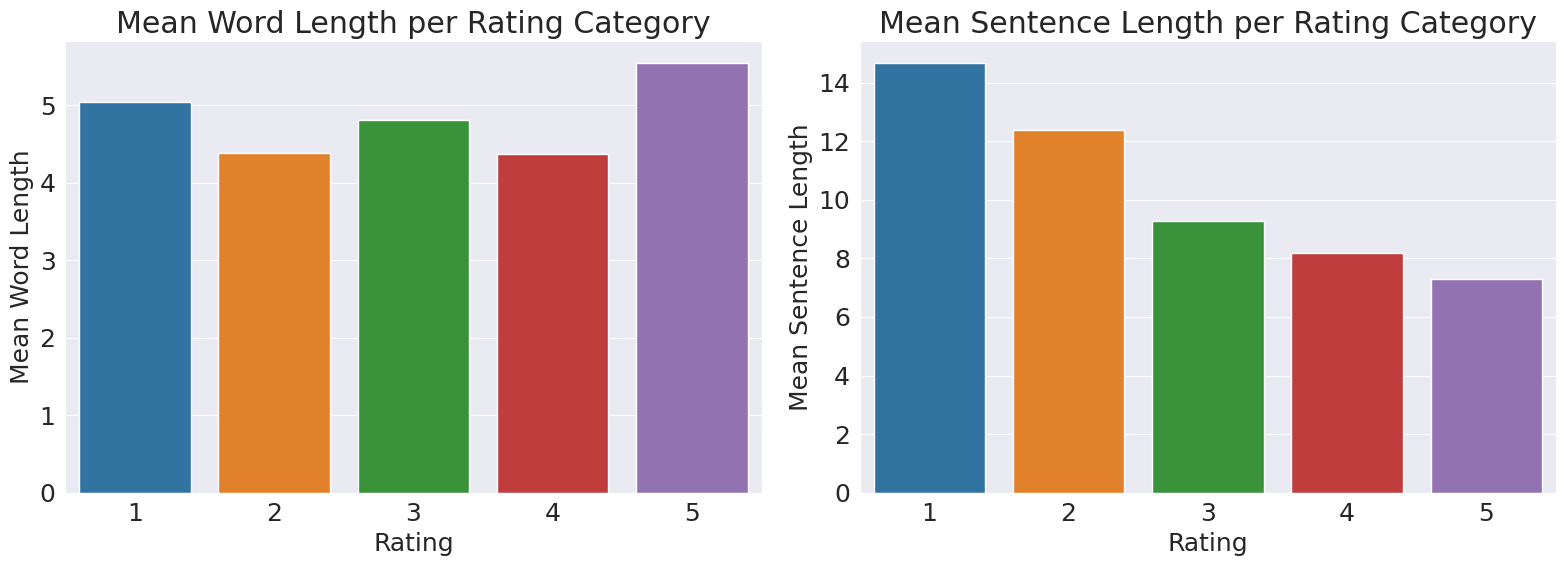

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Mean Word length
sns.barplot(x='sentiment', y='mean_word_length', data=df_mean_lengths, ax=axs[0])
axs[0].set_title('Mean Word Length per Rating Category')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Mean Word Length')

# Mean Sentence Length 
sns.barplot(x='sentiment', y='mean_sent_length', data=df_mean_lengths, ax=axs[1])
axs[1].set_title('Mean Sentence Length per Rating Category')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Mean Sentence Length')

plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()

Die vorhergehenden Plots zeigen relativ Interessante Dinge auf. Generell kann gesagt werden, dass schlechte Bewertungen tendenziell laenger sind und mehr Saetze enthalten. Dies deutet darauf hin, dass unzufriedene Kunden detailierteres Feedback geben. 

In [19]:
# Clean up added columns
df_mcd.drop(['char_count', 'word_count', 'mean_word_length', 'sent_count', 'mean_sent_length'], axis=1, inplace=True)
df_mcd.head()

,text,sentiment
0,Why does it look like someone spit on my food?...,1
1,It'd McDonalds. It is what it is as far as the...,4
2,Made a mobile order got to the speaker and che...,1
3,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5
4,"I repeat my order 3 times in the drive thru, a...",1


## Haeufigkeit von Begriffen
Bevor wir die Haeufigkeit von Begriffen analysieren, ist es notwendig, die Datensaetze zu bereinigen, um valide Ergebnisse zu erzielen. Es ist wichtig, irrelevante Daten wie HTML-Tags und Zeichensetzung zu entfernen, da diese in der folgenden Analyse zu Verzerrungen fuehren koennen. Durch die Umwandlung aller Woerter in Kleinbuchstaben erreichen wir eine gewisse Standardisierung, die uns konsistentere Resultate liefert. Zudem erlaubt das Entfernen von Stoppwoertern, die ueblicherweise wenig zur Information beitragen, die Konzentration auf wirklich relevante Begriffe. Dies stellt sicher, dass unsere Analyse praezise und informativ ist.

### Reinigen der Reviews

Was hier sicherlich auch noch interessant waere ist 'Stemming' und 'Lemmatization'.
- Stemming: Reduziert Woerter auf ihre Basis, z.B. aus 'jumps', 'jumping', 'jumped' wird 'jump'
- Lemmatization: Reduziert Woerter auf ihre lexikalische Grundform, bietet hoehere semantische Genauigkeit als Stemming. 

In [20]:
og_text = df_mcd['text'][3]
df_mcd['text'] = df_mcd['text'].apply(clean_text)

print('Original Text: {}'.format(og_text))
print('Cleaned Text: {}'.format(df_mcd['text'][3]))

Original Text: My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ customer service was quick and p
Cleaned Text: my mc crispy chicken sandwich was  customer service was quick and p


In [21]:
df_mcd.head()

,text,sentiment
0,why does it look like someone spit on my food\...,1
1,it would mcdonalds it is what it is as far as ...,4
2,made a mobile order got to the speaker and che...,1
3,my mc crispy chicken sandwich was customer se...,5
4,i repeat my order 3 times in the drive thru an...,1


### Anlegen eines Wort - Haeufigkeits Mappings

In [22]:
df_mcd['word_list'] = df_mcd['text'].apply(lambda x: x.split())
df_mcd.head()

,text,sentiment,word_list
0,why does it look like someone spit on my food\...,1,"[why, does, it, look, like, someone, spit, on,..."
1,it would mcdonalds it is what it is as far as ...,4,"[it, would, mcdonalds, it, is, what, it, is, a..."
2,made a mobile order got to the speaker and che...,1,"[made, a, mobile, order, got, to, the, speaker..."
3,my mc crispy chicken sandwich was customer se...,5,"[my, mc, crispy, chicken, sandwich, was, custo..."
4,i repeat my order 3 times in the drive thru an...,1,"[i, repeat, my, order, 3, times, in, the, driv..."


In [23]:
# Create a list of all words and the frequency of each word
word_list = []
for index, row in df_mcd.iterrows():
    word_list += row['word_list']

print('Total Words: {}'.format(len(word_list)))
most_common_words = Counter(word_list).most_common(10)
print('Most Common Words: {}'.format(most_common_words))

# Could also use nltk.FreqDist
# word_freq = nltk.FreqDist(word_list)

Total Words: 745516
Most Common Words: [('the', 34542), ('and', 24344), ('to', 19818), ('i', 19674), ('a', 14896), ('was', 12806), ('is', 12538), ('it', 10745), ('not', 10721), ('they', 9338)]


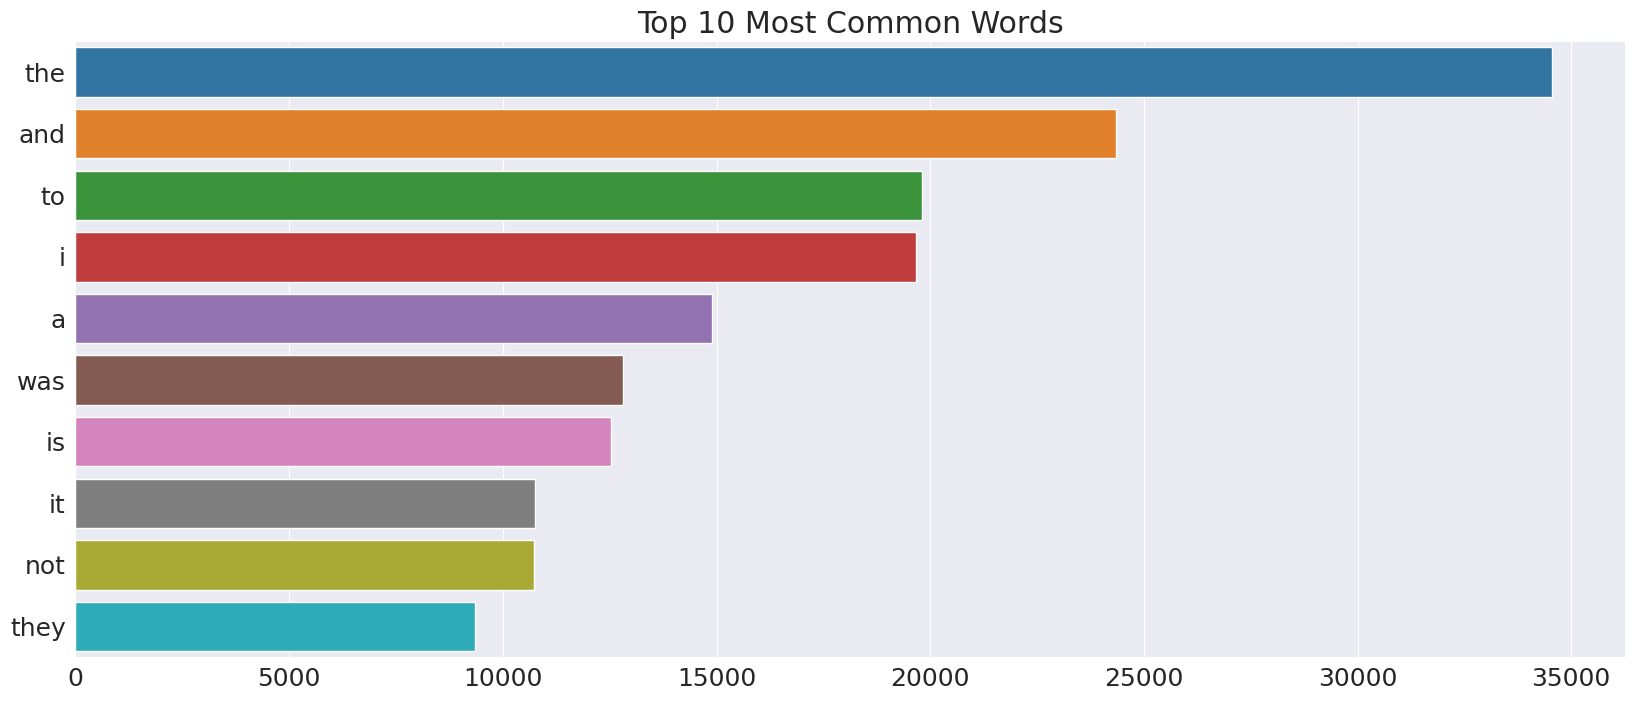

In [24]:
# Create a list for all words and a list for the frequencies
words = [word for word,_ in most_common_words]
freqs = [freq for _,freq in most_common_words]

sns.barplot(x=freqs, y=words)
plt.title('Top 10 Most Common Words')
plt.show()

### Haeufigkeit von Bi-grammen
Woerter fuer sich alleine geben meistens nicht den gesamten Kontext wieder. Abhaengig von der Position im Satz koennen sie sogar komplett unterschiedliche Bedeutungen haben. Mit der Betrachtung der Bi-Grams koennen wir ein besseres Verstaendnis fuer den Kontext bekommen, in dem Worte verwendet werden. Des Weiteren hilft diese Analyse gaengige Phrasen und Ausdruecke zu identifizieren, welche haeufig in Reviews verwendet werden, z.B. 'good service', 'cold food' etc.

In [25]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df_mcd['text'])

print('Total Bigrams: {}'.format(bigrams.shape[1]))
print('Shape: {}'.format(bigrams.shape))       

Total Bigrams: 157099
Shape: (33396, 157099)


In [26]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

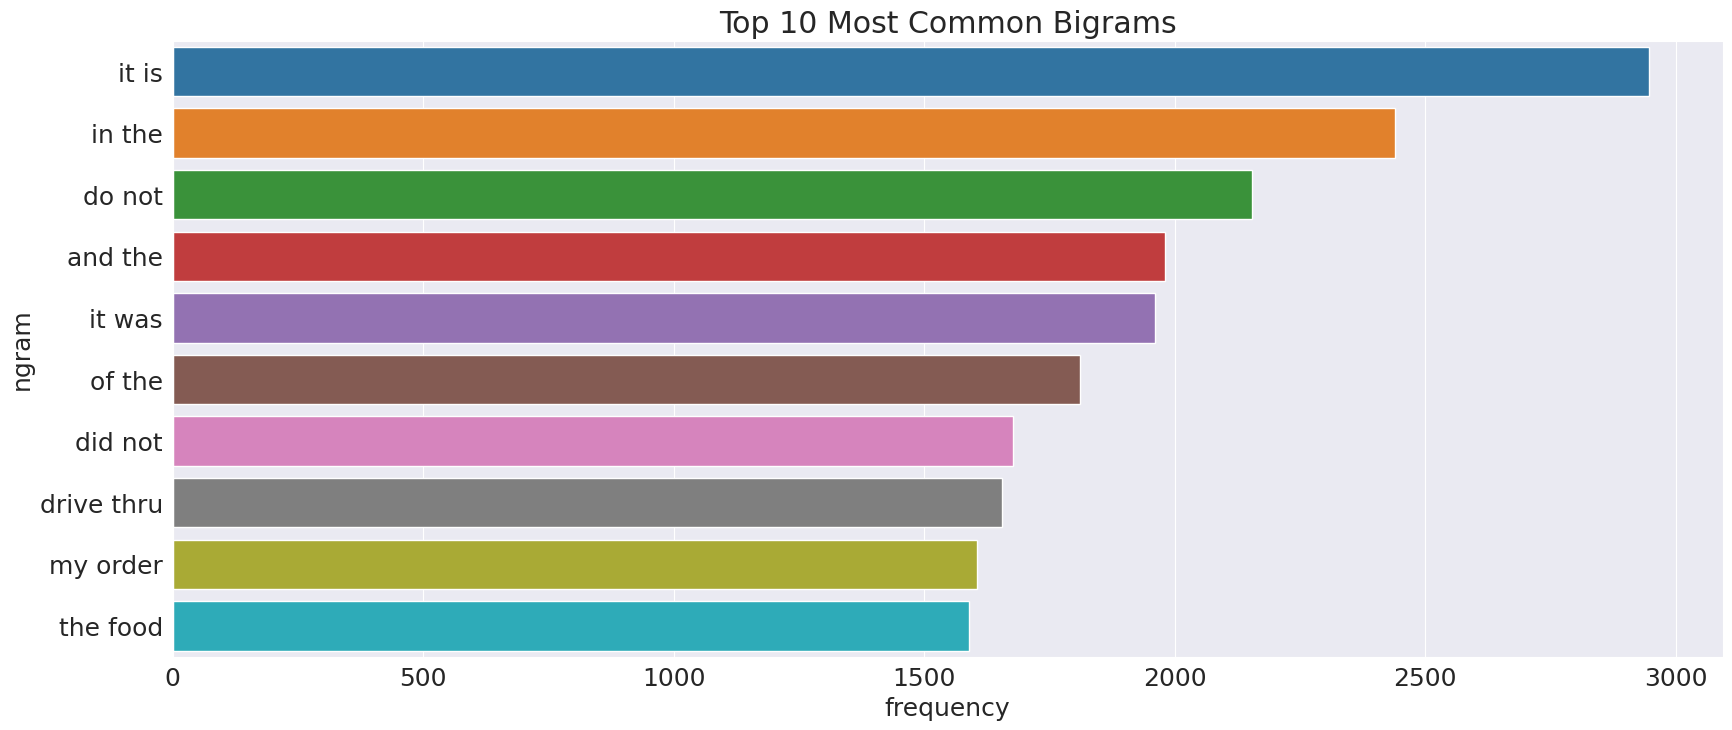

In [27]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Common Bigrams')
plt.show()

Bis auf 'worst mcdonalds' scheinen die Bi-Grams entweder positiv, oder nichts-aussagend zu sein. Hier fehlt uns oft ein weiteres Wort um z.B. bei 'customer service', um eine Bewertung ueber das Sentiment machen zu koennen. Hier waere es interessant zu schauen inwiefern sich die haeufigsten Woerter und BiGramme zwischen negativen und postiven reviews unterscheiden.

### Auftrennung in 'positive' und 'negative' reviews

Da die Labels des McDonalds Datensatzes 'multiclass' sind, muss zunaechst eine Entscheidung getroffen werden, welche Reviews 'postiv' und welche 'negativ' sind. Der Einfachheit halber haben wir uns fuer folgende Aufteilung entschieden:
- Rating 3 wird entfernt, weder positiv noch negativ
- Ratings < 3 sind negativ
- Ratings > 3 sind positiv

In [28]:
# Remove 3 star reviews
df_mcd = df_mcd[df_mcd['text'] != 3]
df_mcd.head()

,text,sentiment,word_list
0,why does it look like someone spit on my food\...,1,"[why, does, it, look, like, someone, spit, on,..."
1,it would mcdonalds it is what it is as far as ...,4,"[it, would, mcdonalds, it, is, what, it, is, a..."
2,made a mobile order got to the speaker and che...,1,"[made, a, mobile, order, got, to, the, speaker..."
3,my mc crispy chicken sandwich was customer se...,5,"[my, mc, crispy, chicken, sandwich, was, custo..."
4,i repeat my order 3 times in the drive thru an...,1,"[i, repeat, my, order, 3, times, in, the, driv..."


In [29]:
# Map to binary
df_mcd['sentiment'] = df_mcd['sentiment'].map(lambda x: 1 if x > 3 else 0)  
df_mcd.head()

,text,sentiment,word_list
0,why does it look like someone spit on my food\...,0,"[why, does, it, look, like, someone, spit, on,..."
1,it would mcdonalds it is what it is as far as ...,1,"[it, would, mcdonalds, it, is, what, it, is, a..."
2,made a mobile order got to the speaker and che...,0,"[made, a, mobile, order, got, to, the, speaker..."
3,my mc crispy chicken sandwich was customer se...,1,"[my, mc, crispy, chicken, sandwich, was, custo..."
4,i repeat my order 3 times in the drive thru an...,0,"[i, repeat, my, order, 3, times, in, the, driv..."


In [30]:
negative_reviews = df_mcd[df_mcd['sentiment'] == 0]
positive_reviews = df_mcd[df_mcd['sentiment'] == 1]

print('Number of Negative Reviews: {}'.format(len(negative_reviews)))
print('Number of Positive Reviews: {}'.format(len(positive_reviews)))

Number of Negative Reviews: 17335
Number of Positive Reviews: 16061


In [31]:
# Create a list of all words and the frequency of each word for negative reviews and positive reviews
negative_word_list = []
for index, row in negative_reviews.iterrows():
    negative_word_list += row['word_list']

most_common_negative_words = Counter(negative_word_list).most_common(10)
neg_freqs = [freq for _,freq in most_common_negative_words]     
neg_words = [word for word,_ in most_common_negative_words]

positive_word_list = []
for index, row in positive_reviews.iterrows():
    positive_word_list += row['word_list']

most_common_positive_words = Counter(positive_word_list).most_common(10)
pos_freqs = [freq for _,freq in most_common_positive_words]
pos_words = [word for word,_ in most_common_positive_words]

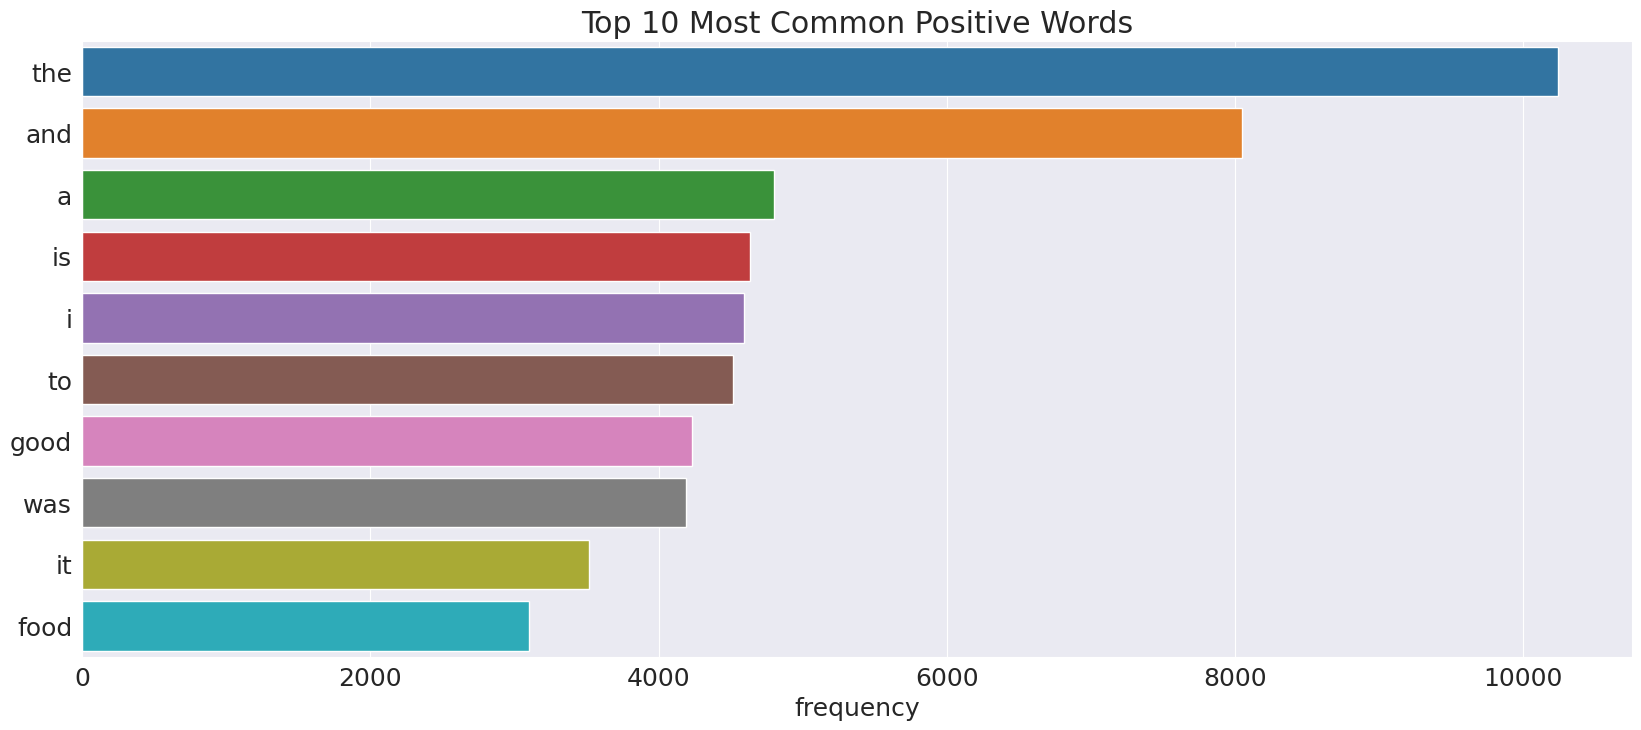

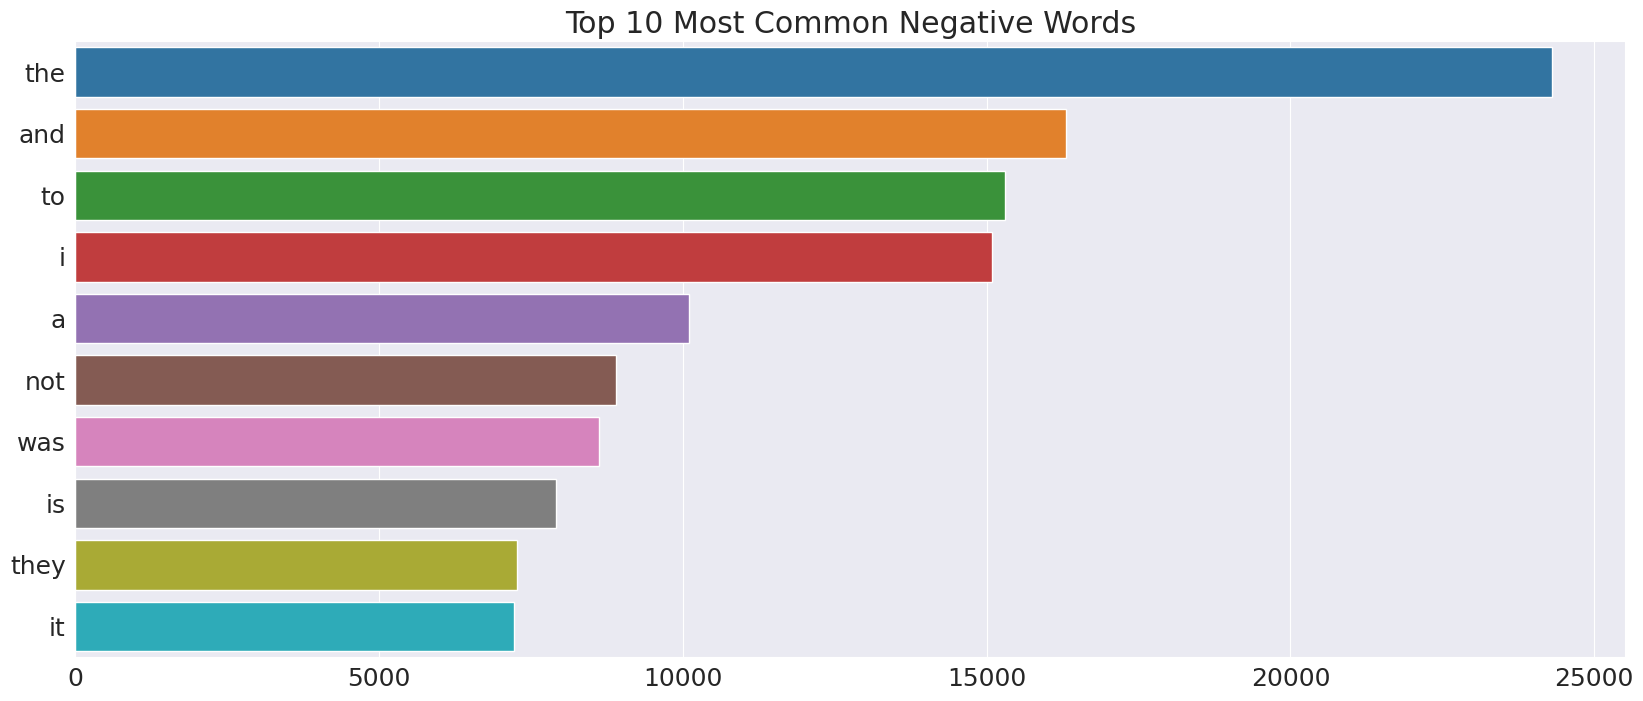

In [32]:
sns.barplot(x=pos_freqs, y=pos_words)   
plt.title('Top 10 Most Common Positive Words')
plt.xlabel('frequency')
plt.show()

sns.barplot(x=neg_freqs, y=neg_words)
plt.title('Top 10 Most Common Negative Words')
plt.show()

In [33]:
cv_neg = CountVectorizer(ngram_range=(2,2))
bigrams_neg = cv_neg.fit_transform(negative_reviews['text'])

print('Negative - Total Bigrams: {}'.format(bigrams_neg.shape[1]))
print('Shape: {}'.format(bigrams_neg.shape))   

cv_pos = CountVectorizer(ngram_range=(2,2))
bigrams_pos = cv_pos.fit_transform(positive_reviews['text'])

print('Positive - Total Bigrams: {}'.format(bigrams_pos.shape[1]))
print('Shape: {}'.format(bigrams_pos.shape))    

Negative - Total Bigrams: 121059
Shape: (17335, 121059)
Positive - Total Bigrams: 59732
Shape: (16061, 59732)


In [34]:
count_values_neg = bigrams_neg.toarray().sum(axis=0)
ngram_freq_neg = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv_neg.vocabulary_.items()], reverse = True))
ngram_freq_neg.columns = ["frequency", "ngram"]

count_values_pos = bigrams_pos.toarray().sum(axis=0)
ngram_freq_pos = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv_pos.vocabulary_.items()], reverse = True))
ngram_freq_pos.columns = ["frequency", "ngram"]

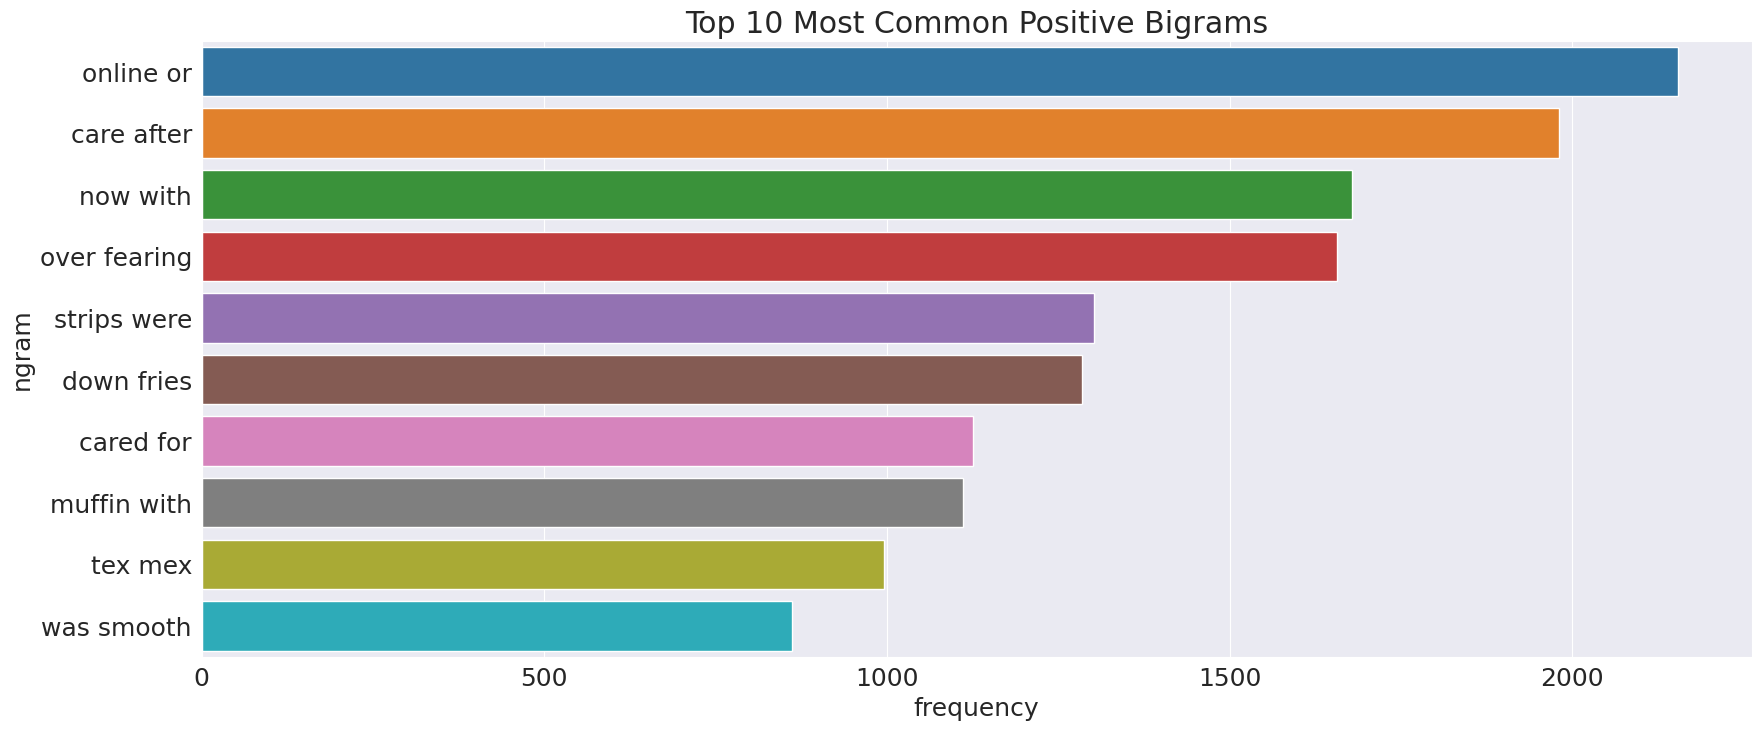

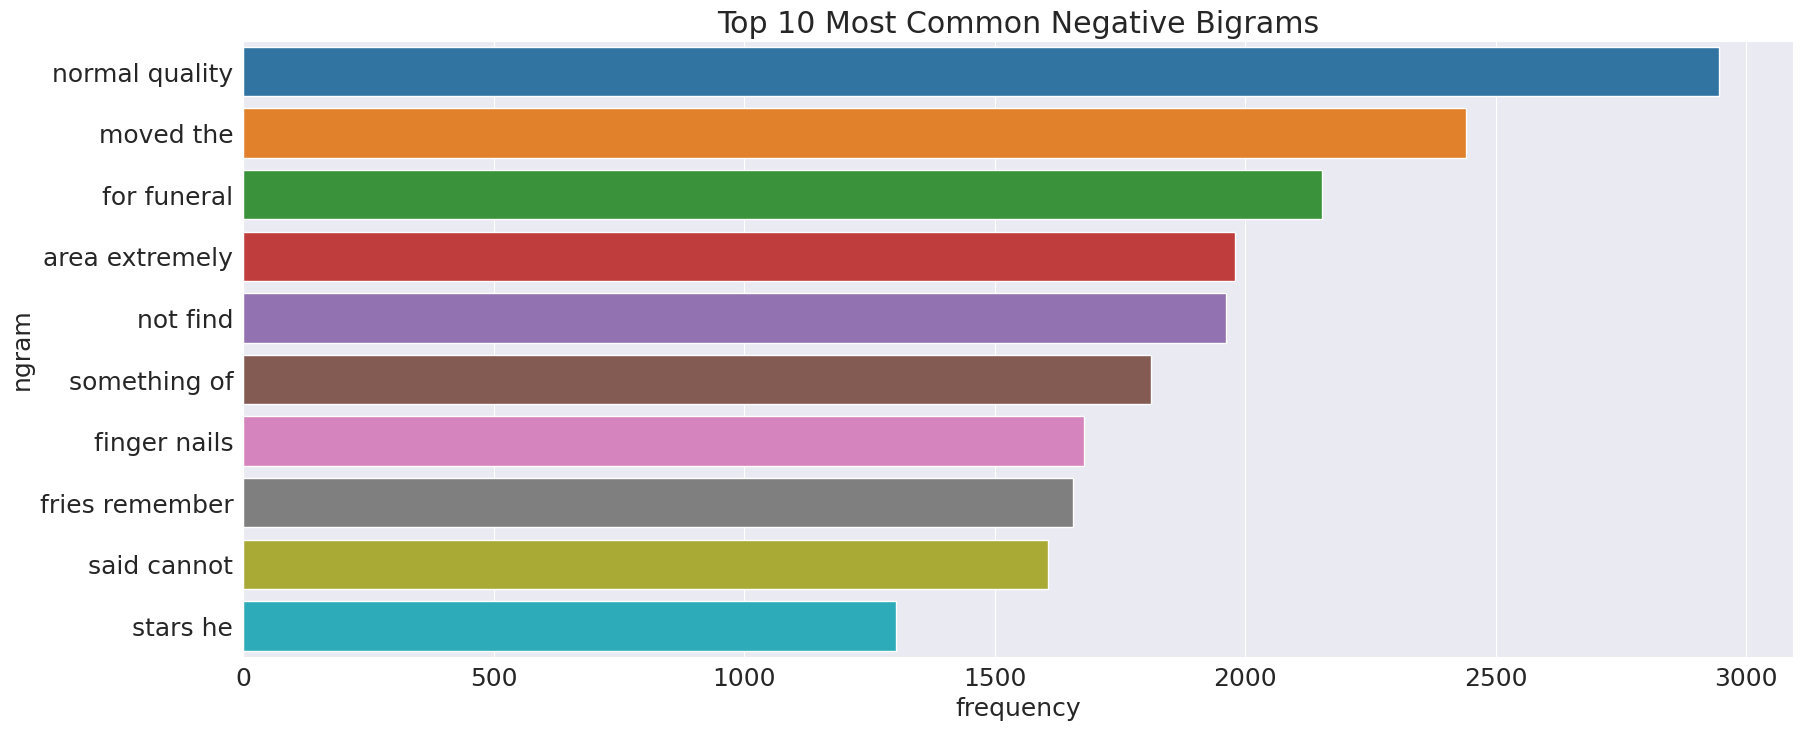

In [35]:
sns.barplot(x=ngram_freq_pos['frequency'][:10], y=ngram_freq_pos['ngram'][:10])
plt.title('Top 10 Most Common Positive Bigrams')
plt.show()

sns.barplot(x=ngram_freq_neg['frequency'][:10], y=ngram_freq_neg['ngram'][:10])
plt.title('Top 10 Most Common Negative Bigrams')
plt.show()

## Genauere Betrachtung des IMDB Datasets

In [36]:
df_imdb['char_count'] = df_imdb['text'].apply(len)
df_imdb['word_count'] = df_imdb['text'].apply(lambda x: len(word_tokenize(x)))
df_imdb['mean_word_length'] = df_imdb['text'].apply(lambda x: np.mean([len(word) for word in word_tokenize(x)]))
df_imdb['sent_count'] = df_imdb['text'].apply(lambda x: len(sent_tokenize(x)))

In [37]:
df_imdb['mean_sent_length'] = df_imdb['word_count'] / df_imdb['sent_count']  
df_imdb.head()    

,text,sentiment,char_count,word_count,mean_word_length,sent_count,mean_sent_length
0,One of the other reviewers has mentioned that ...,1,1761,380,3.828947,10,38.000000
1,A wonderful little production. <br /><br />The...,1,998,201,4.174129,7,28.714286
2,I thought this was a wonderful way to spend ti...,1,926,205,3.741463,4,51.250000
3,Basically there's a family where a little boy ...,0,748,175,3.491429,6,29.166667
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,1317,283,3.851590,9,31.444444


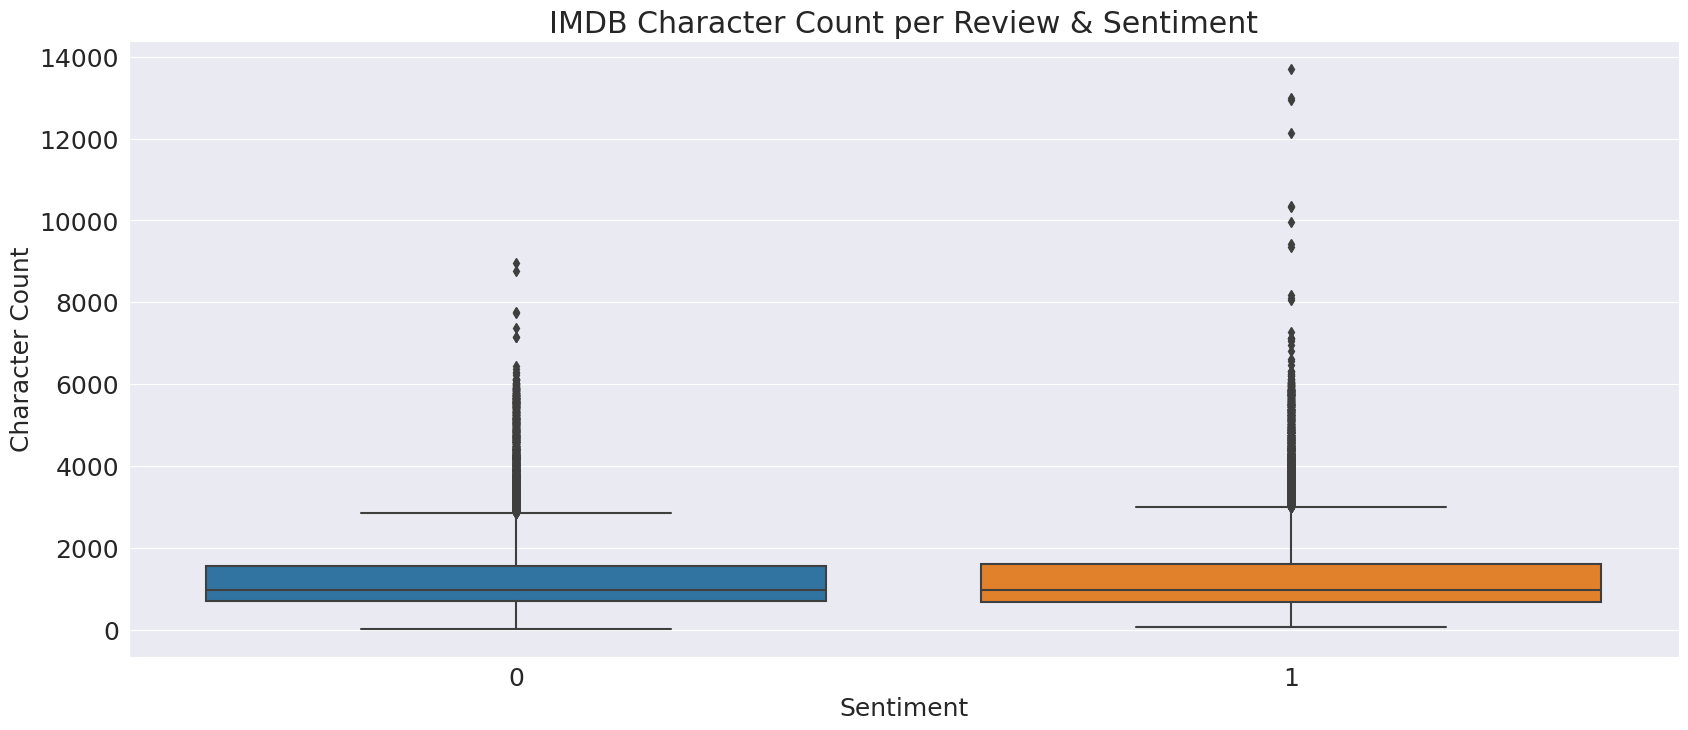

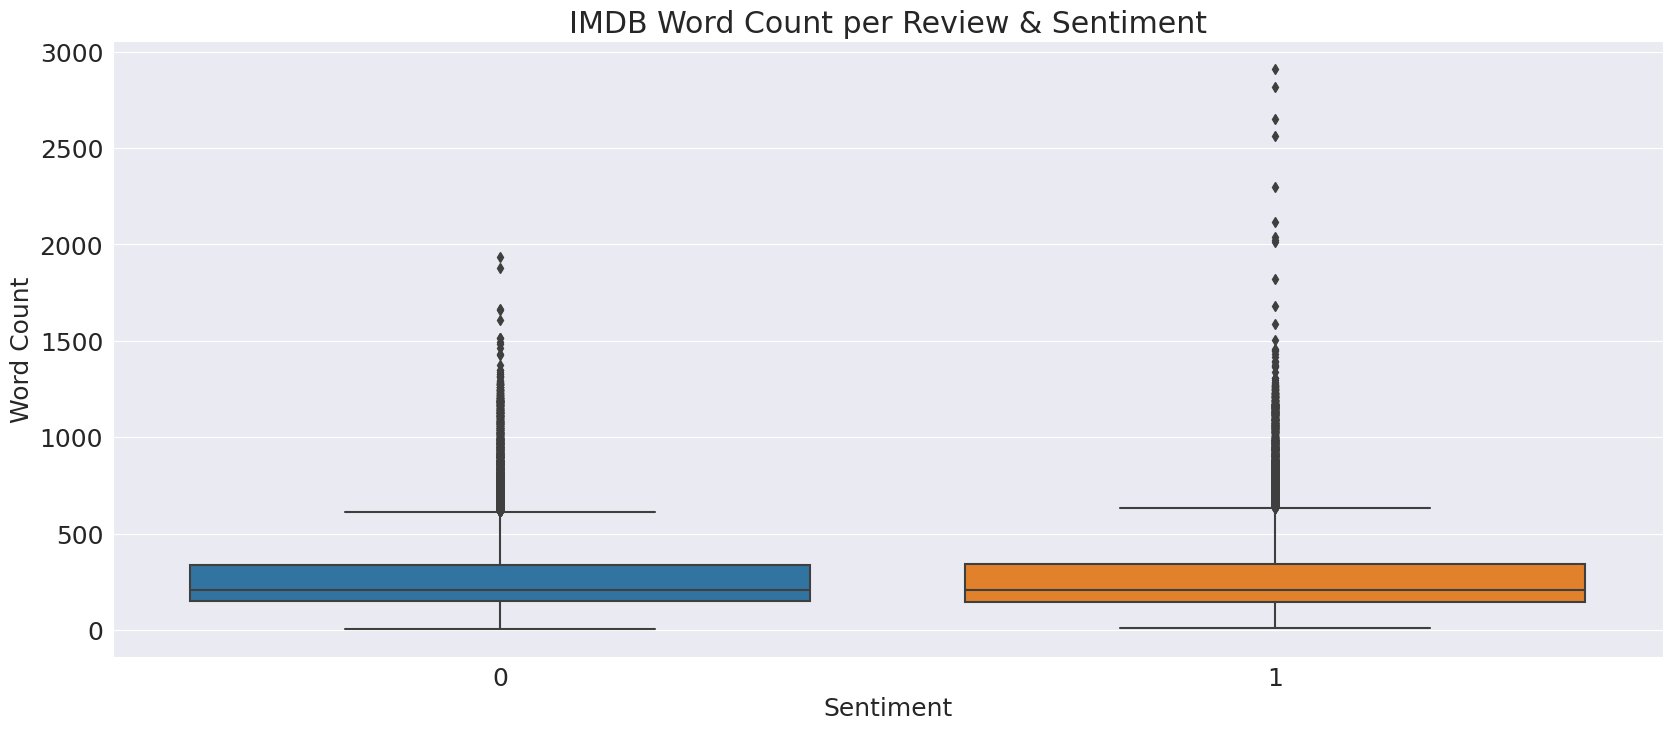

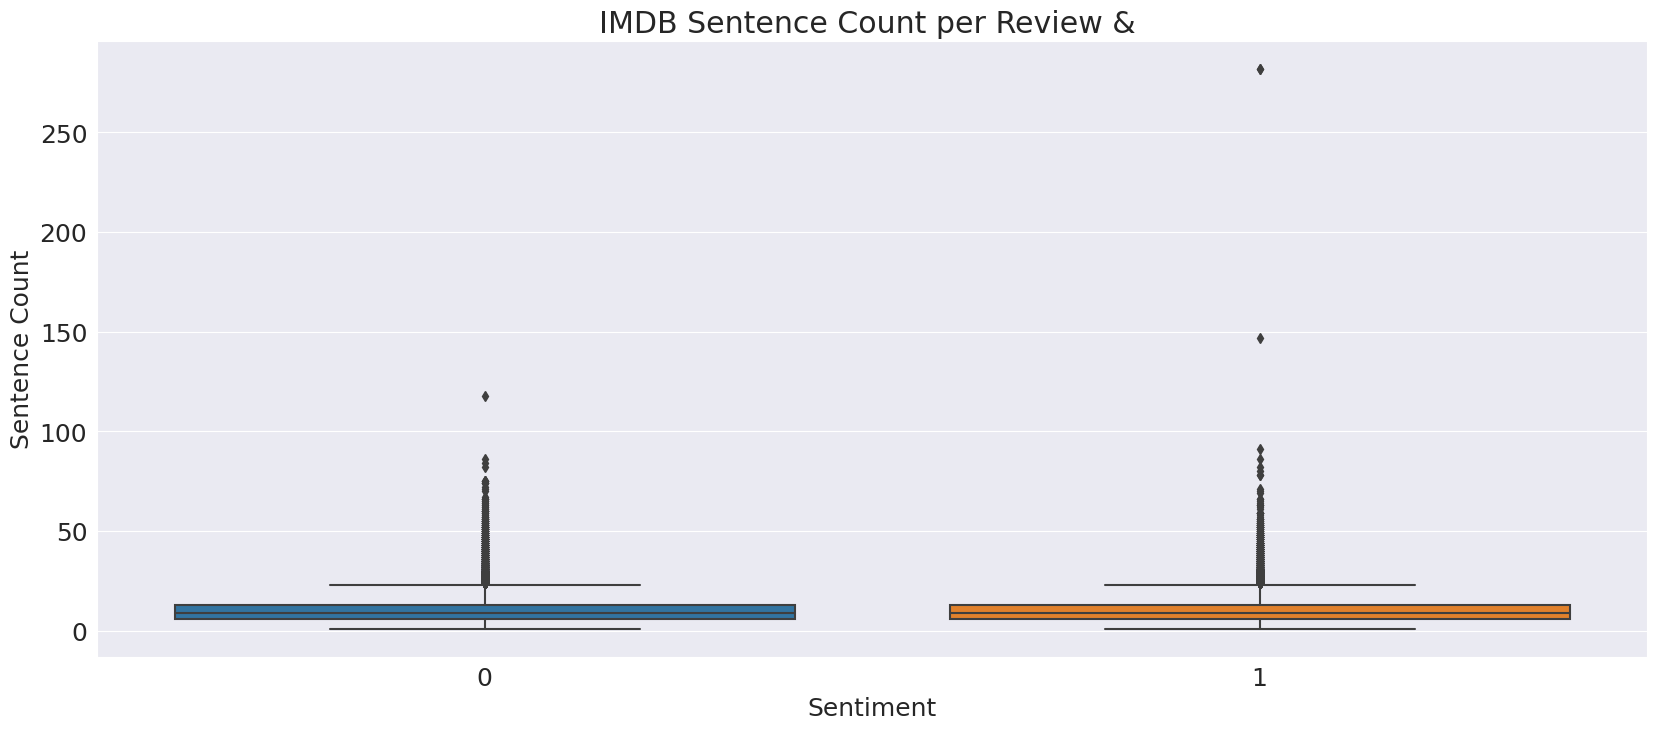

In [38]:
# Character count
sns.boxplot(x='sentiment', y='char_count', data=df_imdb)
plt.title('IMDB Character Count per Review & Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Character Count')   
plt.show()

# Word count
sns.boxplot(x='sentiment', y='word_count', data=df_imdb) 
plt.title('IMDB Word Count per Review & Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.show()

# Sentence count
sns.boxplot(x='sentiment', y='sent_count', data=df_imdb)
plt.title('IMDB Sentence Count per Review & ')
plt.xlabel('Sentiment')
plt.ylabel('Sentence Count')
plt.show()

In [39]:
df_mean_lengths = df_imdb.groupby('sentiment').agg({'mean_word_length': 'mean', 'mean_sent_length': 'mean'}).reset_index()

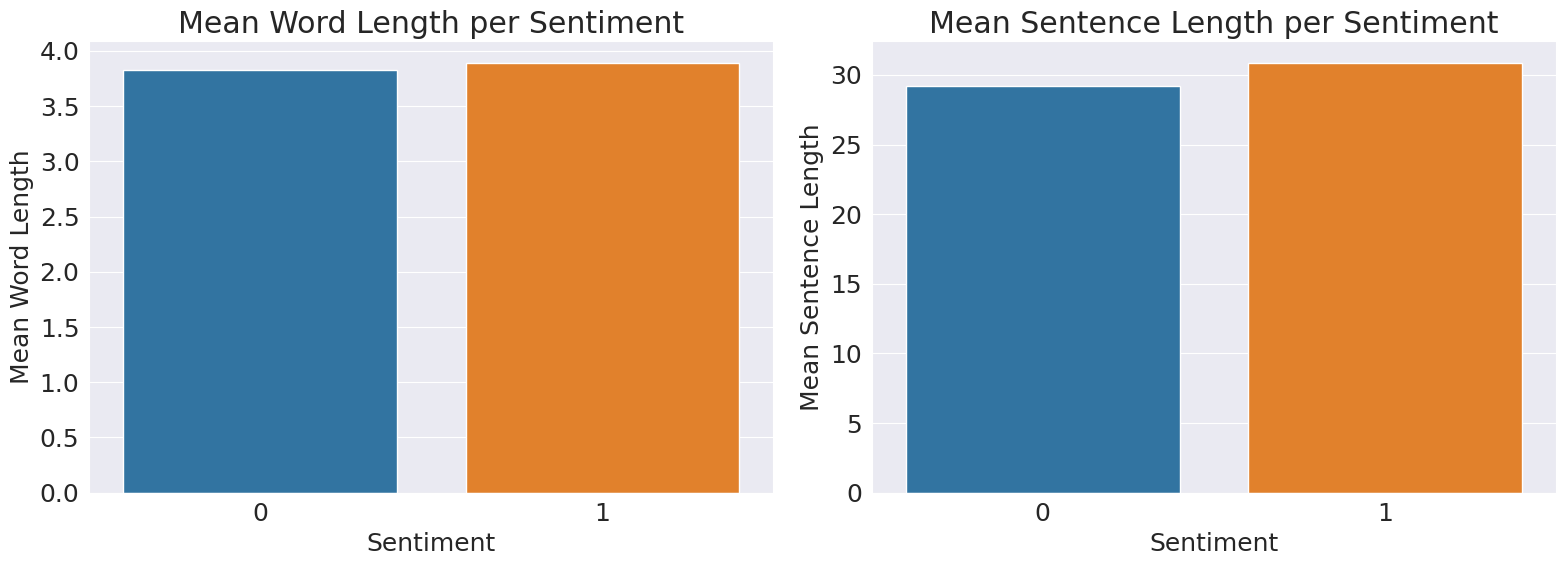

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Mean Word length
sns.barplot(x='sentiment', y='mean_word_length', data=df_mean_lengths, ax=axs[0])
axs[0].set_title('Mean Word Length per Sentiment')
axs[0].set_xlabel('Sentiment')
axs[0].set_ylabel('Mean Word Length')

# Mean Sentence Length 
sns.barplot(x='sentiment', y='mean_sent_length', data=df_mean_lengths, ax=axs[1])
axs[1].set_title('Mean Sentence Length per Sentiment')
axs[1].set_xlabel('Sentiment')
axs[1].set_ylabel('Mean Sentence Length')

plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()

### Haeufigkeit von Begriffen im IMDB Dataset

In [41]:
og_text = df_imdb['text'][0]
df_imdb['text'] = df_imdb['text'].apply(clean_text)

print('Original Text: {}'.format(og_text))
print('Cleaned Text: {}'.format(df_imdb['text'][0]))

Original Text: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is

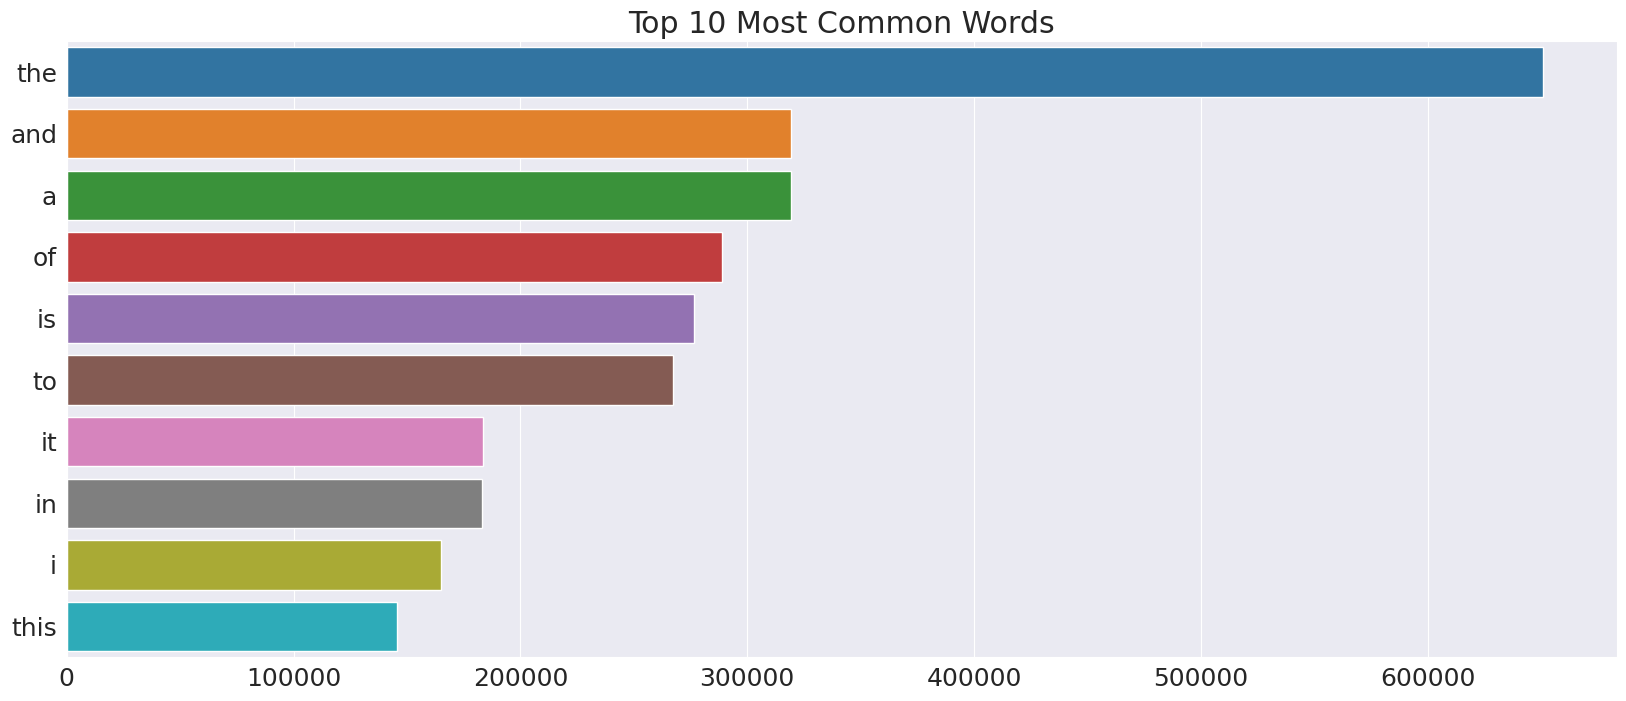

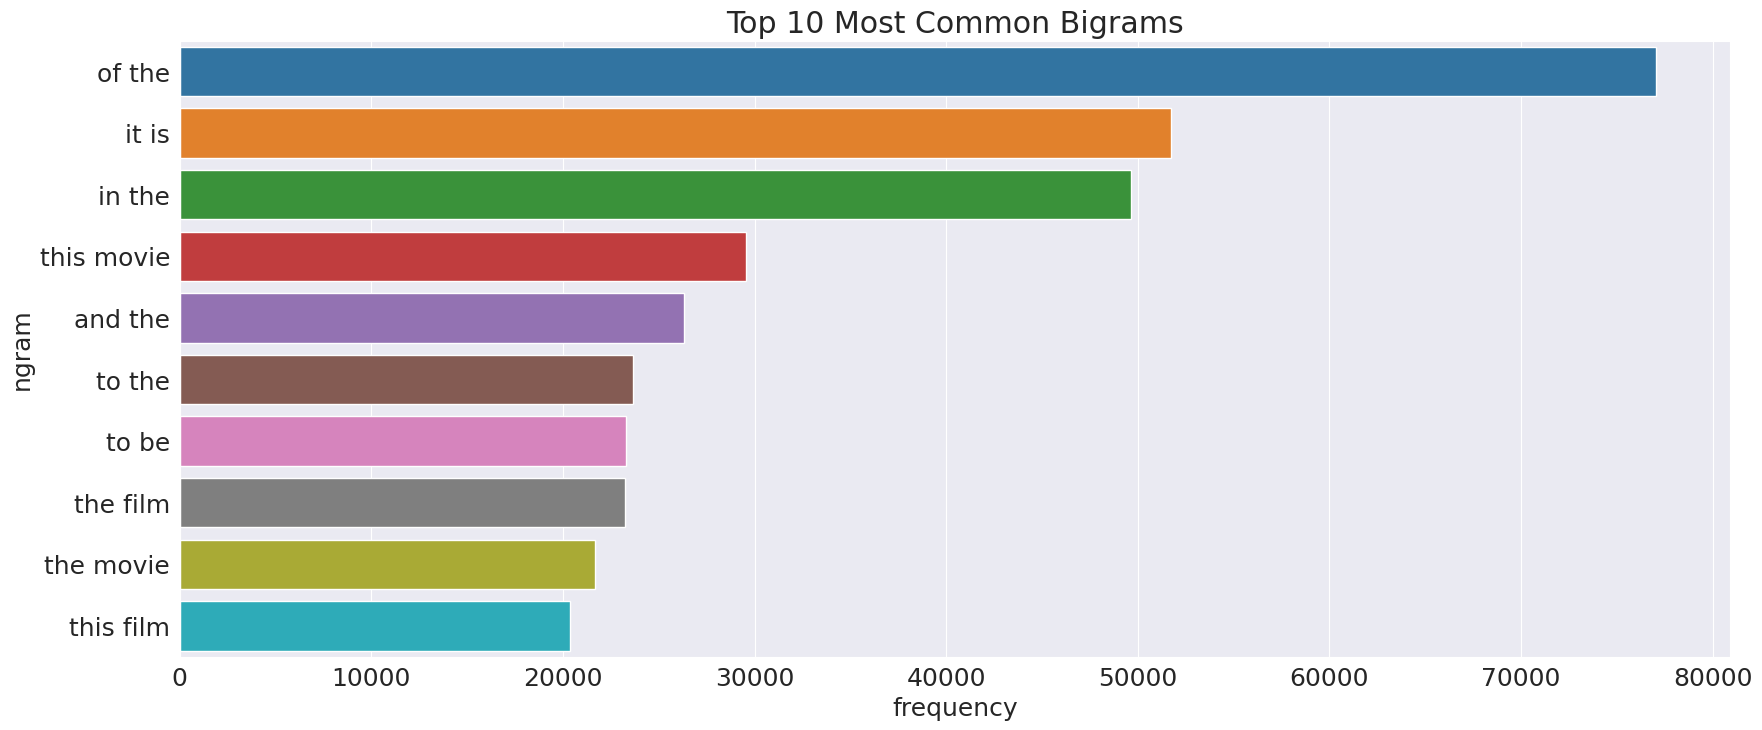

In [42]:
df_imdb['word_list'] = df_imdb['text'].apply(lambda x: x.split())
df_imdb.head()

word_list = []
for index, row in df_imdb.iterrows():
    word_list += row['word_list']

most_common_words = Counter(word_list).most_common(10)

words = [word for word,_ in most_common_words]
freqs = [freq for _,freq in most_common_words]

sns.barplot(x=freqs, y=words)
plt.title('Top 10 Most Common Words')
plt.show()

cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df_imdb['text'])

count_values = bigrams.sum(axis=0)
count_values = np.asarray(count_values).squeeze()
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]


sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Common Bigrams')
plt.show()

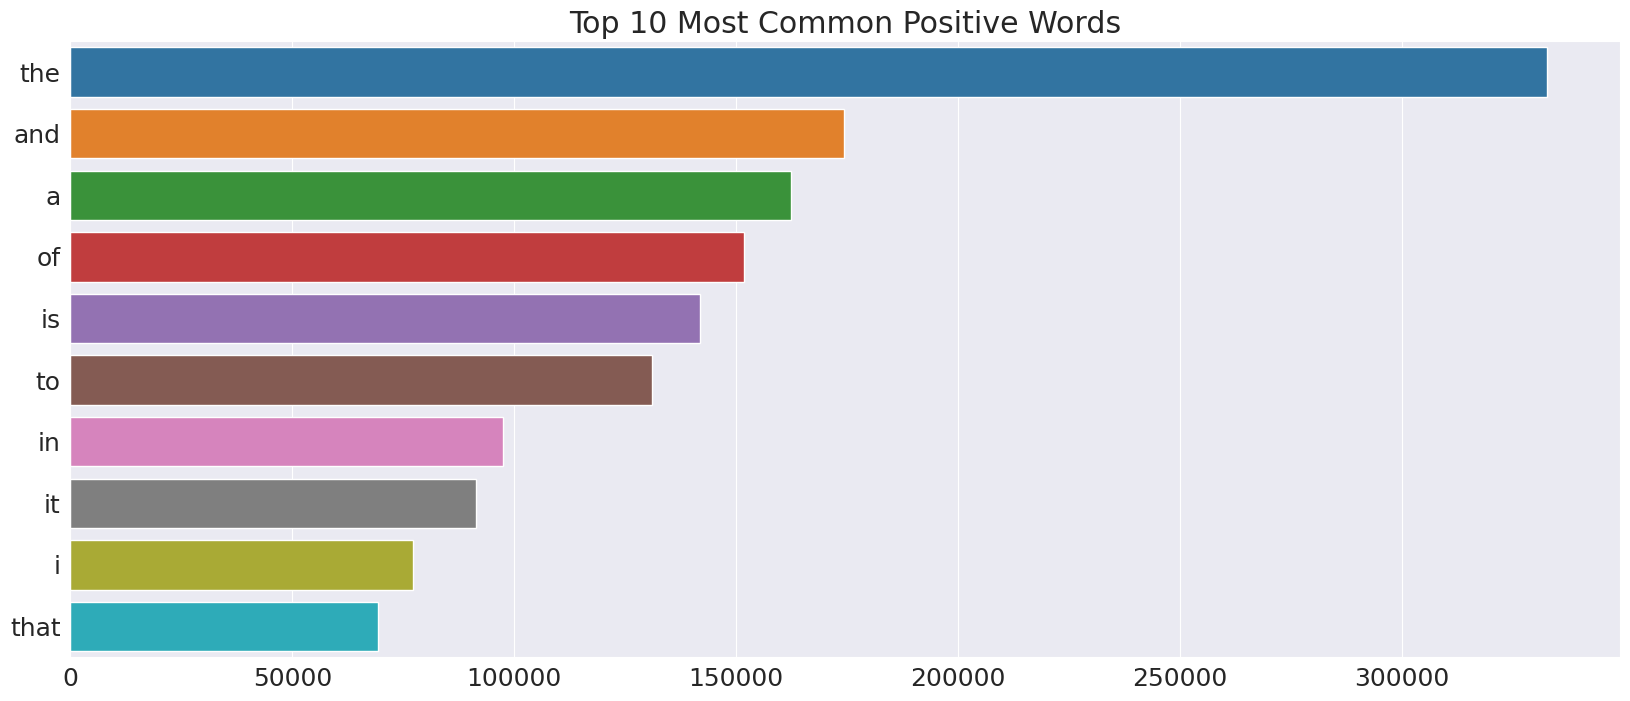

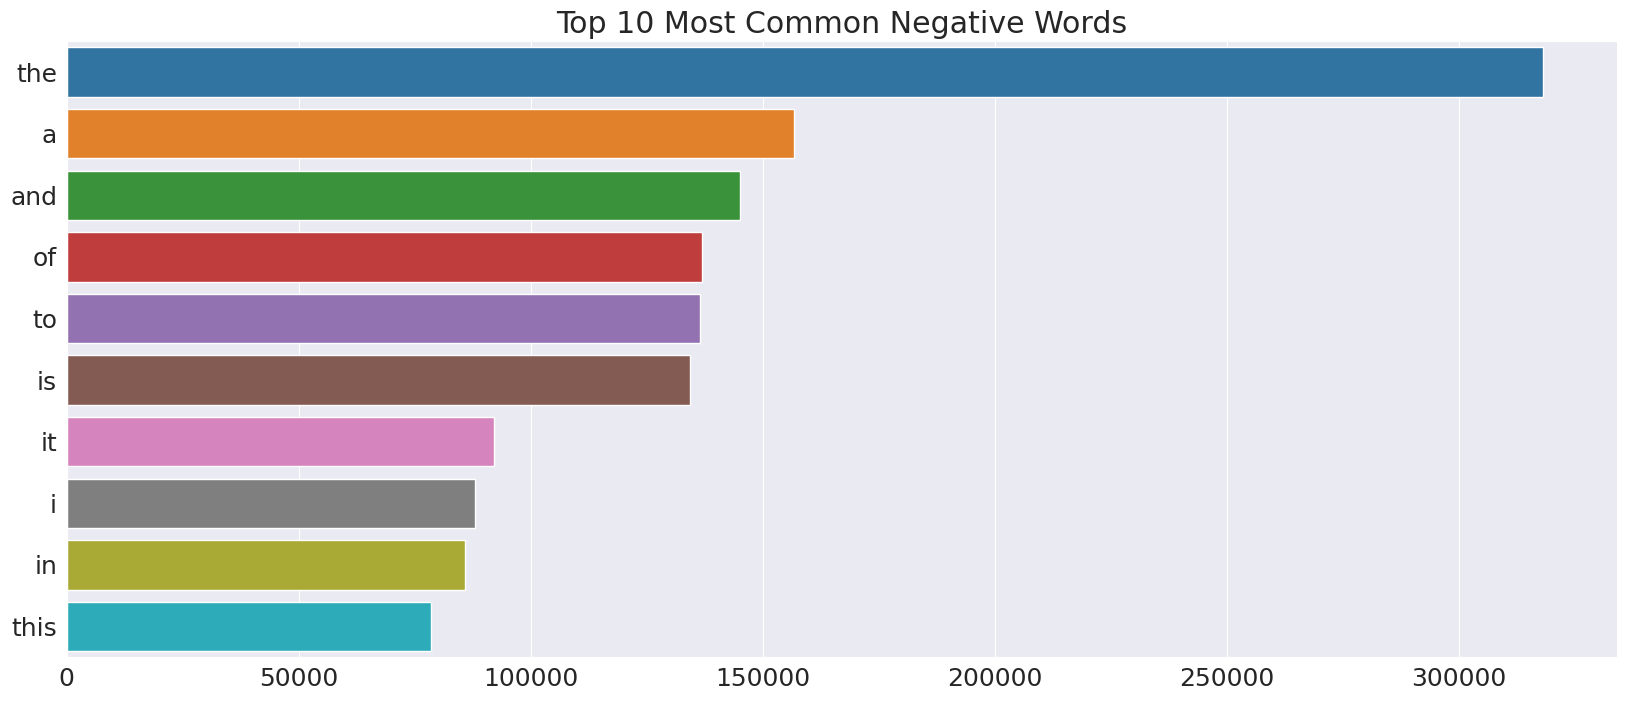

In [43]:
positive_reviews = df_imdb[df_imdb['sentiment'] == 1]
negative_reviews = df_imdb[df_imdb['sentiment'] == 0]

# Create a list of all words and the frequency of each word for negative reviews and positive reviews
negative_word_list = []
for index, row in negative_reviews.iterrows():
    negative_word_list += row['word_list']

most_common_negative_words = Counter(negative_word_list).most_common(10)
neg_freqs = [freq for _,freq in most_common_negative_words]     
neg_words = [word for word,_ in most_common_negative_words]

positive_word_list = []
for index, row in positive_reviews.iterrows():
    positive_word_list += row['word_list']

most_common_positive_words = Counter(positive_word_list).most_common(10)
pos_freqs = [freq for _,freq in most_common_positive_words]
pos_words = [word for word,_ in most_common_positive_words]

sns.barplot(x=pos_freqs, y=pos_words)   
plt.title('Top 10 Most Common Positive Words')
plt.show()

sns.barplot(x=neg_freqs, y=neg_words)
plt.title('Top 10 Most Common Negative Words')
plt.show()

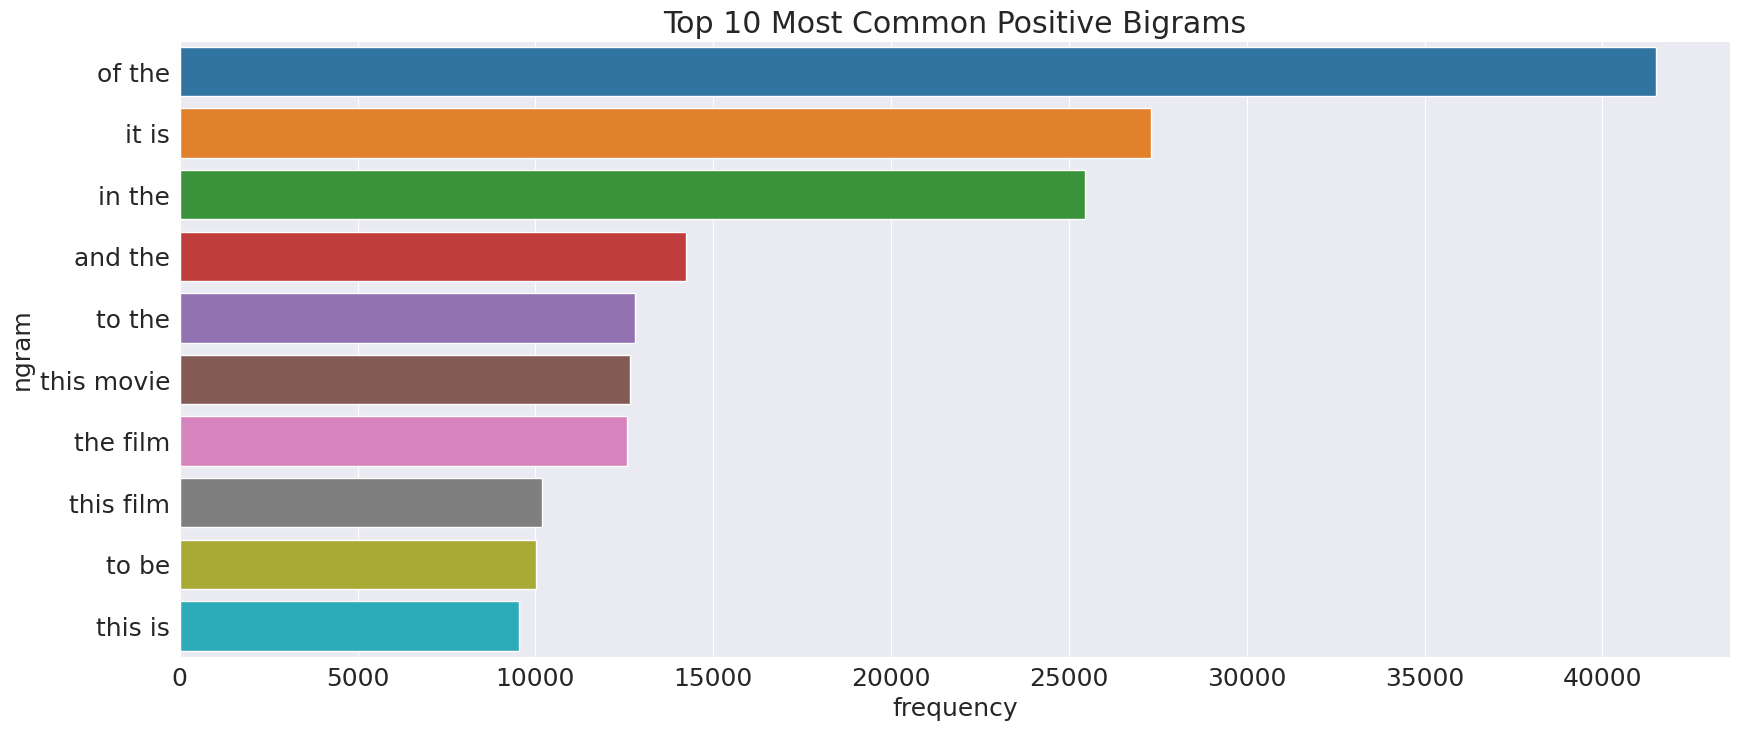

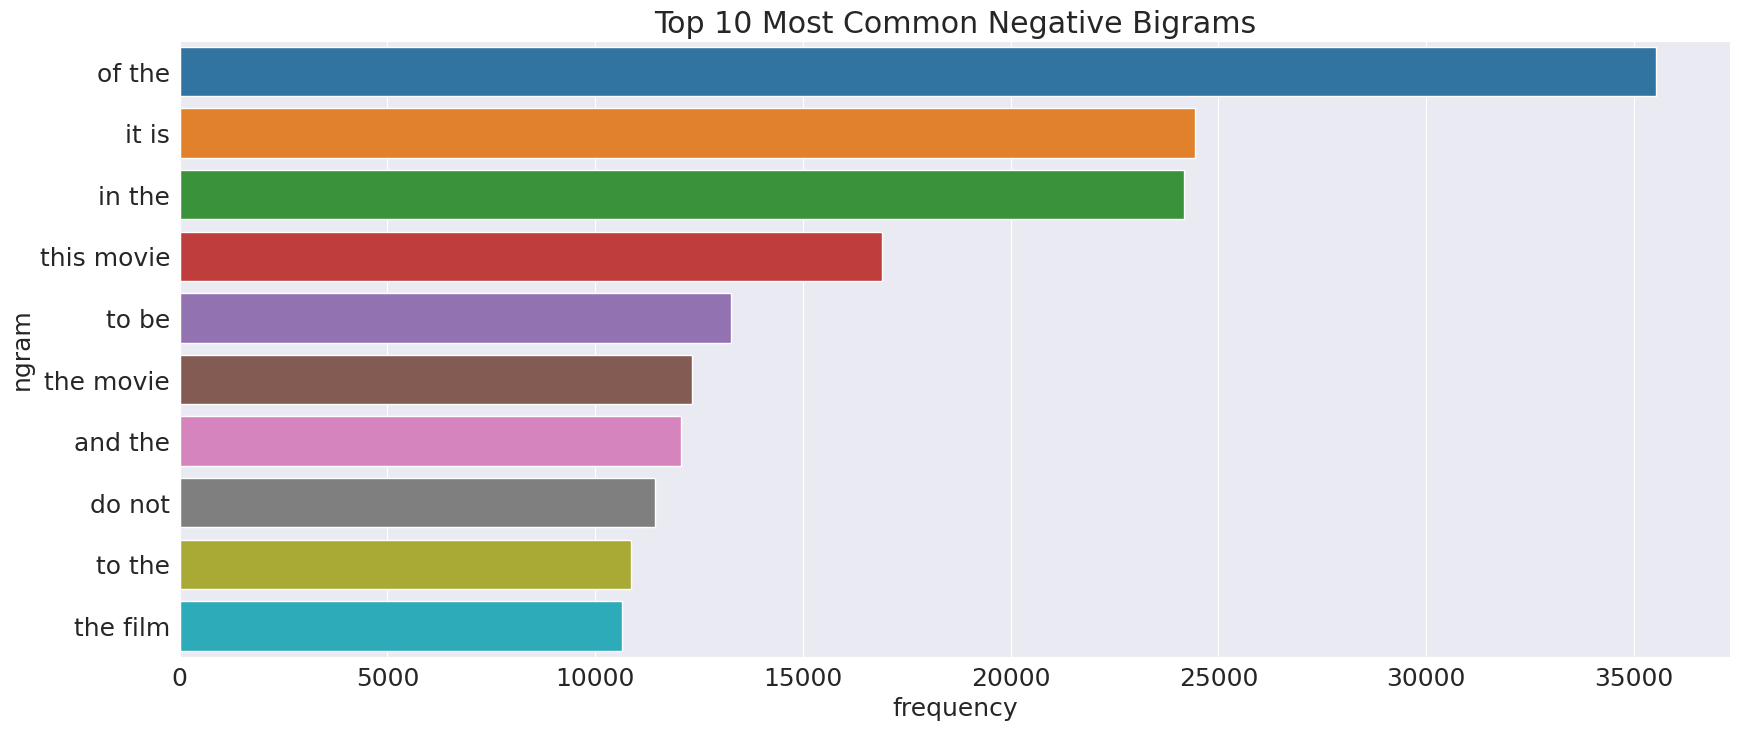

In [44]:
cv_neg = CountVectorizer(ngram_range=(2,2))
bigrams_neg = cv_neg.fit_transform(negative_reviews['text'])

cv_pos = CountVectorizer(ngram_range=(2,2))
bigrams_pos = cv_pos.fit_transform(positive_reviews['text'])

count_values_neg = bigrams_neg.sum(axis=0)
count_values_neg = np.asarray(count_values_neg).squeeze() 

ngram_freq_neg = pd.DataFrame(sorted([(count_values_neg[i], k) for k, i in cv_neg.vocabulary_.items()], reverse = True))
ngram_freq_neg.columns = ["frequency", "ngram"]

count_values_pos = bigrams_pos.sum(axis=0)
count_values_pos = np.asarray(count_values_pos).squeeze() 

ngram_freq_pos = pd.DataFrame(sorted([(count_values_pos[i], k) for k, i in cv_pos.vocabulary_.items()], reverse = True))
ngram_freq_pos.columns = ["frequency", "ngram"]

sns.barplot(x=ngram_freq_pos['frequency'][:10], y=ngram_freq_pos['ngram'][:10])
plt.title('Top 10 Most Common Positive Bigrams')
plt.show()

sns.barplot(x=ngram_freq_neg['frequency'][:10], y=ngram_freq_neg['ngram'][:10])
plt.title('Top 10 Most Common Negative Bigrams')
plt.show()